param_num: 454954
[0, 0.7165228271484376, 2.6330456542968754, 4.549568481445313, 6.46609130859375, 8.382614135742188, 10.299136962890625, 12.215659790039062, 14.1321826171875, 16.048705444335937, 17.965228271484374, 19.88175109863281, 21.79827392578125, 23.714796752929686, 25.631319580078124, 27.54784240722656, 29.464365234375, 31.380888061523436, 33.29741088867188, 35.21393371582032, 37.13045654296876, 39.0469793701172, 40.96350219726564, 42.88002502441408, 44.79654785156252, 46.71307067871096, 48.629593505859404, 50.546116333007845, 52.462639160156286, 54.37916198730473, 56.29568481445317, 58.21220764160161, 60.12873046875005]
param_num: 454954
[0, 4.016522827148438, 22.433045654296876, 40.84956848144532, 59.26609130859376, 77.6826141357422, 96.09913696289064, 114.51565979003908, 132.93218261718752, 151.34870544433596, 169.7652282714844, 188.18175109863284, 206.59827392578129, 225.01479675292973, 243.43131958007817, 261.8478424072266, 280.264365234375, 298.68088806152343, 317.0974108

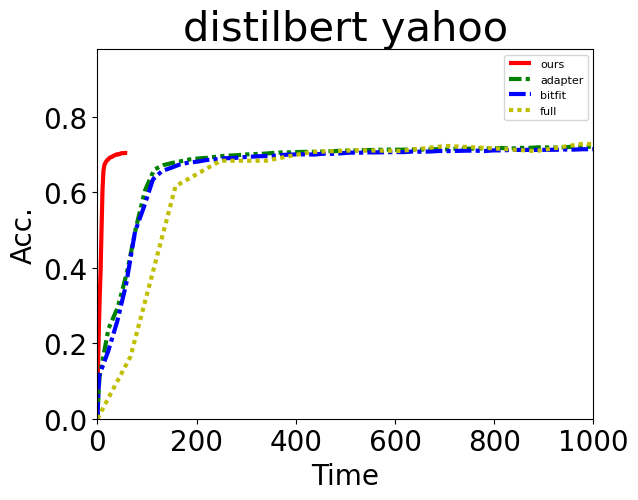

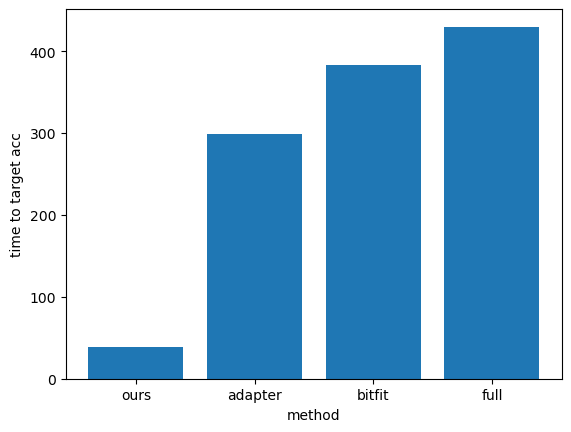

In [4]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "yahoo"
model = "distilbert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedFwd_distilbert_yahoo_lr0.01_client_num_5000_numerical.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_100_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_bitfit.log",
    "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":1,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.7
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()

param_num: 454954
[0, 2.8165228271484377, 15.233045654296875, 27.649568481445314, 40.066091308593755, 52.482614135742196, 64.89913696289064, 77.31565979003908, 89.73218261718752, 102.14870544433596, 114.5652282714844, 126.98175109863284, 139.39827392578127, 151.8147967529297, 164.23131958007815, 176.6478424072266, 189.06436523437503, 201.48088806152347, 213.8974108886719, 226.31393371582035, 238.7304565429688, 251.14697937011724, 263.5635021972657, 275.9800250244141, 288.3965478515625, 300.8130706787109, 313.2295935058593, 325.64611633300774, 338.06263916015615, 350.47916198730456, 362.895684814453, 375.3122076416014, 387.7287304687498]
param_num: 454954
[0, 4.016522827148438, 22.433045654296876, 40.84956848144532, 59.26609130859376, 77.6826141357422, 96.09913696289064, 114.51565979003908, 132.93218261718752, 151.34870544433596, 169.7652282714844, 188.18175109863284, 206.59827392578129, 225.01479675292973, 243.43131958007817, 261.8478424072266, 280.264365234375, 298.68088806152343, 317

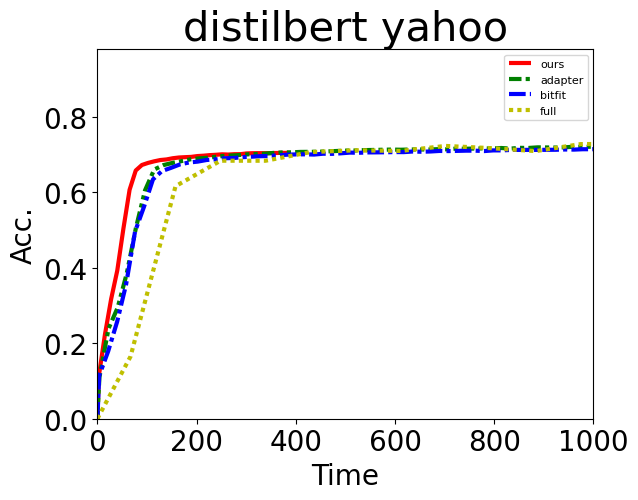

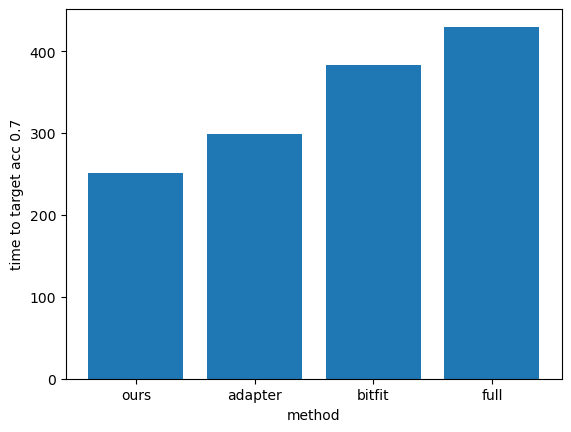

In [5]:
import os 
import sys
import matplotlib.pyplot as plt
import numpy as np


dataset = "yahoo"
model = "distilbert"

logging_file = {
    "ours":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedFwd_distilbert_yahoo_lr0.01_client_num_5000_numerical.log",
    "adapter":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_100_adapter.log",
    "bitfit":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_bitfit.log",
    "full":"/data/wyz/FedNLP/experiments/distributed/transformer_exps/run_tc_exps/log/end2end/distilbert_yahoo/fedsgd_distilbert_yahoo_lr0.01_client_num_10_full.log"
}

train_time_dict = {"ours":8,"adapter":12,"bitfit":12,"full":20}
local_data_num_dict = {"agnews":15,"yahoo":18}
comm_bandwidth = 10 * 1024**2 /8  # k * 1024**2 /8 => k Mb/s 

target_acc = 0.7
time_to_acc_dict ={}

eval_frequence = 5 if dataset == "yahoo" else 1
linestyle = [(0, ( )), (0, (3, 1,1,1,1,1)), (0, (4, 1,1,1)), (0, (1, 1)),(0, (2, 4)), (0, (5, 1)),(0,(3,1,3,1)),(0,(4,3,3,1))]*100
colors=['r','g','b','y','c','m','k',"tan"] * 100
lw = 3

def round_to_time(round,eval_frequence,comm_time,method,local_data_num,adhoc=None):
    train_time = train_time_dict[method]
    if adhoc == None:
        adhoc = [1,1,1]
    else:
        adhoc = list(map(int,adhoc.split(",")))
    time_list = [0]
    if method == "ours":
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    else:
        time = (train_time*local_data_num*adhoc[0] + comm_time*local_data_num)/60
    time_list.append(time)
    for i in range(2,round):
        v_num = adhoc[i-1] if i-1 < len(adhoc) else adhoc[-1]
        if method == "ours":
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        else:
            time += (train_time*local_data_num*v_num*eval_frequence + comm_time*local_data_num)/60
        time_list.append(time)
    return time_list
    
def get_time_to_target_acc(target_acc,acc_list,time_list):
    n = len(acc_list)
    i = 0
    while i < n and acc_list[i] < target_acc:
        i += 1
    return time_list[i] if i<n else 10000

for i,method in enumerate(logging_file):
    file = logging_file[method]
    local_data_num = local_data_num_dict[dataset]
    with open(file) as f:
        for line in f:
            if "Trainable" in line:
                param_num = int(line[line.rfind(":")+2:-2])
                print(f"param_num: {param_num}")
                break
        comm_time = param_num * 4 / comm_bandwidth
        acc = [0]
        if "," in file:
            adhoc = file.split("_")[-1].split(".")[0]
        else:
            adhoc = None
        for line in f:
            if "'acc':" in line:
                acc.append(float(line[line.rfind("'acc':")+7:line.rfind(",")]))
        time_list = round_to_time(len(acc),eval_frequence,comm_time,method,local_data_num,adhoc)
        time_to_acc_dict[method] = get_time_to_target_acc(target_acc,acc,time_list)
        print(time_list)
        plt.plot(time_list, acc, linestyle=linestyle[i], color=colors[i],label=method,linewidth=lw)
plt.xlabel("Time",fontsize=20)
plt.ylabel("Acc.",fontsize=20)
plt.xticks(size = 20)
plt.xlim(0,1000)
plt.yticks(size = 20)
plt.ylim(0,0.98)
plt.legend(fontsize=8)
plt.title(f"{model} {dataset}",fontsize=30)
plt.show()

# 提取键和值的列表
keys = list(time_to_acc_dict.keys())
values = list(time_to_acc_dict.values())

# 绘制柱状图
plt.bar(keys, values)

# 设置坐标轴标签和标题
plt.xlabel('method')
plt.ylabel(f'time to target acc {target_acc}')
# plt.title('Bar Chart')

# 显示图形
plt.show()